### Download the dataset

In [1]:
import os
import shutil
try:
    shutil.rmtree("/content/hi")
except:
    pass

try:
    os.remove("/content/hi.zip")
except:
    pass

try:
    shutil.rmtree("/content/wandb")
except:
    pass

In [2]:
%%capture
# !gdown https://drive.google.com/uc?id=1oG_Alz4wmqIMJxNPTZNuvYo1beMwTFHn
!gdown https://drive.google.com/uc?id=1TkaNm9ucnEn3S5Pz3D5SRFiroFgx4fjs
!unzip "/content/hi.zip"
!pip install wandb

In [3]:
!nvidia-smi

Thu May  6 16:55:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbCallback

### Load the data

In [5]:
# Load the training lexicons
with open("hi/lexicons/hi.translit.sampled.train.tsv") as f:
    training_lines = f.readlines()
training_pairs = [line.strip("\n").split("\t") for line in training_lines]
training_map = dict([(example[1], example[0]) for example in training_pairs])

# Load the validation lexicons
with open("hi/lexicons/hi.translit.sampled.dev.tsv") as f:
    validation_lines = f.readlines()
validation_pairs = [line.strip("\n").split("\t") for line in validation_lines]
validation_map = dict([(example[1], example[0]) for example in validation_pairs])

# Load the test lexicons
with open("hi/lexicons/hi.translit.sampled.test.tsv") as f:
    test_lines = f.readlines()
test_pairs = [line.strip("\n").split("\t") for line in test_lines]
test_map = dict([(example[1], example[0]) for example in test_pairs])

# Number of training examples
M_train = len(training_map.keys())

# Number of validation examples
M_val = len(validation_map.keys())

# Number of test examples
M_test = len(test_map.keys())

print(f"Number of training examples = {M_train}")
print(f"Number of validation examples = {M_val}")
print(f"Number of test examples = {M_test}")
print()

Number of training examples = 41345
Number of validation examples = 4321
Number of test examples = 4442



### Prepare the data

We have used "tab" for the START sequence character and "newline" as the END sequence character.

In [6]:
def extract_data_info(data_dict):
    """
    Returns important information about the data.
    """
    input_words = []
    target_words = []
    input_characters = []
    target_characters = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")
        # Add the characters to the respective character lists
        input_characters = list(set(input_characters + list(key)))
        target_characters = list(set(target_characters + list(data_dict[key])))

    # Sort the input characters
    input_characters = sorted(list(set(input_characters)))
    # Sort the target characters
    target_characters = target_characters + ["\t", "\n"]
    target_characters = sorted(list(set(target_characters)))

    # Number of unique tokens in the source language
    num_input_tokens = len(input_characters)
    # Number of unique tokens in the target language
    num_target_tokens = len(target_characters)

    # Max input word length
    max_encoder_seq_length = max([len(word) for word in input_words])
    # Max output word length
    max_decoder_seq_length = max([len(word) for word in target_words])

    print(f"Number of unique input characters: {num_input_tokens}")
    print(f"Number of unique output characters: {num_target_tokens}")
    print()
    print(f"Maximum sequence length for the input: {max_encoder_seq_length}")
    print(f"Maximum sequence length for the output: {max_decoder_seq_length}")

    # Map characters to numerical indices (using +1 to avoid any character being mapped to 0)
    input_char_map = dict([(ch, i + 1) for i, ch in enumerate(input_characters)])
    target_char_map = dict([(ch, i + 1) for i, ch in enumerate(target_characters)])

    return input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map

def make_one_hot_arrays(data_dict, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens):
    """
    This function takes the training/validation/test dictionary as input and produces
    the one-hot encoded versions of the respective data.
    """
    input_words = []
    target_words = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")

    M = len(data_dict.keys())
    encoder_input_array = np.zeros((M, max_encoder_seq_length, num_input_tokens + 1), dtype="float")
    decoder_input_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")
    decoder_output_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")

    for i in range(M):
        source_word = input_words[i]
        target_word = target_words[i]

        # One-hot encoding for the input
        for j, ch in enumerate(source_word):
            encoder_input_array[i, j, input_char_map[ch]] = 1.0

        # One-hot encoding for the output
        for j, ch in enumerate(target_word):
            decoder_input_array[i, j, target_char_map[ch]]= 1.0
            if j >= 1:
                # The decoder output is one step ahead of the decoder input
                decoder_output_array[i, j-1, target_char_map[ch]] = 1.0

    # encoder_input_array = []
    # decoder_input_array = []
    # decoder_output_array = []

    # for i in range(M):
    #     source_word = input_words[i]
    #     target_word = target_words[i]

    #     # Numerical encoding for the source word
    #     encoder_input_array.append([input_char_map[ch] for ch in source_word])

    #     # One-hot encoding for the output
    #     decoder_input_array.append([target_char_map[ch] for ch in target_word])
    #     # The decoder output is one step ahead of the decoder input
    #     decoder_output_array.append([target_char_map[ch] for ch in target_word][1:])

    return input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array

In [7]:
input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map = extract_data_info(training_map)

Number of unique input characters: 26
Number of unique output characters: 64

Maximum sequence length for the input: 20
Maximum sequence length for the output: 21


In [8]:
# Get the one-hot training matrices
input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array = make_one_hot_arrays(training_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_encoder_input_array = keras.preprocessing.sequence.pad_sequences(encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_decoder_input_array = keras.preprocessing.sequence.pad_sequences(decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_decoder_output_array = keras.preprocessing.sequence.pad_sequences(decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_decoder_output_array_oh = np.zeros((padded_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_decoder_output_array_oh[i][j][padded_decoder_output_array[i][j]] = 1.0

In [9]:
# Get the one-hot validation matrices
val_input_words, val_target_words, val_encoder_input_array, val_decoder_input_array, val_decoder_output_array = make_one_hot_arrays(validation_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_val_encoder_input_array = keras.preprocessing.sequence.pad_sequences(val_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_val_decoder_input_array = keras.preprocessing.sequence.pad_sequences(val_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_val_decoder_output_array = keras.preprocessing.sequence.pad_sequences(val_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_val_decoder_output_array_oh = np.zeros((padded_val_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_val_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_val_decoder_output_array_oh[i][j][padded_val_decoder_output_array[i][j]] = 1.0

In [10]:
# Get the one-hot validation matrices
test_input_words, test_target_words, test_encoder_input_array, test_decoder_input_array, test_decoder_output_array = make_one_hot_arrays(test_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_test_encoder_input_array = keras.preprocessing.sequence.pad_sequences(test_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_test_decoder_input_array = keras.preprocessing.sequence.pad_sequences(test_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_test_decoder_output_array = keras.preprocessing.sequence.pad_sequences(test_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_test_decoder_output_array_oh = np.zeros((padded_test_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_test_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_test_decoder_output_array_oh[i][j][padded_test_decoder_output_array[i][j]] = 1.0

In [11]:
# Using label encoding for the encoder inputs (and then find an embedding using the Embedding layer)
encoder_input_array = np.argmax(encoder_input_array, axis=2)
val_encoder_input_array = np.argmax(val_encoder_input_array, axis=2)
test_encoder_input_array = np.argmax(test_encoder_input_array, axis=2)

decoder_input_array = np.argmax(decoder_input_array, axis=2)
val_decoder_input_array = np.argmax(val_decoder_input_array, axis=2)
test_decoder_input_array = np.argmax(test_decoder_input_array, axis=2)

# Dictionaries mapping from indices to characters
reverse_input_char_map = dict((i, char) for char, i in input_char_map.items())
reverse_target_char_map = dict((i, char) for char, i in target_char_map.items())
reverse_target_char_map[0] = "\n"

In [12]:
encoder_input_array[1]

array([ 1, 14, 11,  7,  1, 14,  9, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [13]:
decoder_input_array[1]

array([ 1,  6,  4, 18, 20, 31, 52, 32,  2,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

### Define the model

In [14]:
def define_model(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    num_cells: Number of cells in the encoder and decoder layers
    cell_type: choice of cell type: Simple RNN, LSTM, GRU
    num_encoder_layers: Number of layers in the encoder
    num_decoder_layers: Number of layers in the decoder
    input_embedding_size: Dimenions of the vector to represent each character
    dropout_fraction: fraction of neurons to drop out
    """
    ## ENCODER
    # encoder_input = keras.Input(shape=(None, num_input_tokens), name="EncoderInput")
    encoder_input = keras.Input(shape=(None, ), name="EncoderInput")
    encoder_embedding = keras.layers.Embedding(num_input_tokens + 1, input_embedding_size, name="EncoderInputEmbedding", mask_zero=True)(encoder_input)

    # LSTM/RNN/GRU layer of the encoder
    for i in range(1, num_encoder_layers+1):
        if cell_type=="LSTM":
            if i==num_encoder_layers:
                encoder = keras.layers.LSTM(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.LSTM(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)

            if i==1:
                encoder_outputs, encoder_state_h_1, encoder_state_c_1 = encoder(encoder_embedding)
            if i==2:
                encoder_outputs, encoder_state_h_2, encoder_state_c_2 = encoder(encoder_outputs)
            if i==3:
                encoder_outputs, encoder_state_h_3, encoder_state_c_3 = encoder(encoder_outputs)

        if cell_type=="RNN":
            if i==num_encoder_layers:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, rnn_final_state_1 = encoder(encoder_embedding)
            if i==2:
                whole_sequence_output, rnn_final_state_2 = encoder(whole_sequence_output)
            if i==3:
                whole_sequence_output, rnn_final_state_3 = encoder(whole_sequence_output)

        if cell_type=="GRU":
            if i==num_encoder_layers:
                encoder = keras.layers.GRU(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.GRU(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, gru_final_state_1 = encoder(encoder_embedding)
            if i==2:
                whole_sequence_output, gru_final_state_2 = encoder(whole_sequence_output)
            if i==3:
                whole_sequence_output, gru_final_state_3 = encoder(whole_sequence_output)


    ## DECODER
    decoder_input = keras.Input(shape=(None, ), name="DecoderInput")
    decoder_embedding = keras.layers.Embedding(num_target_tokens + 1, 64, name="DecoderInputEmbedding", mask_zero=True)(decoder_input)


    for i in range(1, num_decoder_layers+1):
        if cell_type=="LSTM":
            decoder_lstm = keras.layers.LSTM(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embedding, initial_state = [encoder_state_h_1, encoder_state_c_1])
            if i==2:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_outputs, initial_state = [encoder_state_h_2, encoder_state_c_2])
            if i==3:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_outputs, initial_state = [encoder_state_h_3, encoder_state_c_3])
                

        if cell_type=="RNN":
            decoder_rnn = keras.layers.SimpleRNN(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_embedding, initial_state = rnn_final_state_1)
            if i==2:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_outputs, initial_state = rnn_final_state_2)
            if i==3:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_outputs, initial_state = rnn_final_state_3)

        if cell_type=="GRU":
            decoder_gru = keras.layers.GRU(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_embedding, initial_state = gru_final_state_1)
            if i==2:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_outputs, initial_state = gru_final_state_2)
            if i==3:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_outputs, initial_state = gru_final_state_3)

    decoder_dense = keras.layers.Dense(num_target_tokens + 1, activation="softmax", name="DecoderDenseLayer") # Softmax picks one character
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = keras.Model([encoder_input, decoder_input], decoder_outputs)

    return model

# Inference Functions

### Inference, LSTM, 1 Decoder Layer

In [15]:
def prepare_inference_model_lstm_1(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]
    # Output of the encoder
    for layer in model.layers:
        if "EncoderLayer" in layer.name:
            _, state_h_enc, state_c_enc = layer.output
    encoder_states = [state_h_enc, state_c_enc]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]
    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if "DecoderLayer1" in layer.name:
            decoder_lstm_first = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer


    decoder_state_input_h = keras.Input(shape=(num_cells,))
    decoder_state_input_c = keras.Input(shape=(num_cells,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm_first(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs)
    decoder_states = [state_h_dec, state_c_dec]

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return encoder_model, decoder_model


def transliterate_word_lstm_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h, c = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = [h, c]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

### Inference: LSTM, 2 Decoder Layers

In [16]:
def prepare_inference_model_lstm_2(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_h_enc_1, state_c_enc_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_h_enc_2, state_c_enc_2 = layer.output
    encoder_states = [state_h_enc_1, state_c_enc_1, state_h_enc_2, state_c_enc_2]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_state_input_h_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_2 = keras.Input(shape=(num_cells,))
    decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
    decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]

    decoder_outputs, state_h_dec_1, state_c_dec_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs_1)
    decoder_outputs, state_h_dec_2, state_c_dec_2 = decoder_2(decoder_outputs, initial_state = decoder_states_inputs_2)


    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs_1 + decoder_states_inputs_2,
                                [decoder_outputs] + [state_h_dec_1, state_c_dec_1, state_h_dec_2, state_c_dec_2])
    
    return encoder_model, decoder_model

def transliterate_word_lstm_2(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h1, c1, h2, c2 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [h1, c1, h2, c2]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

### Inference: LSTM, 3 Decoder Layers

In [17]:
def prepare_inference_model_lstm_3(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_h_enc_1, state_c_enc_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_h_enc_2, state_c_enc_2 = layer.output
        if layer.name =="EncoderLayer3":
            _, state_h_enc_3, state_c_enc_3 = layer.output

    encoder_states = [state_h_enc_1, state_c_enc_1, state_h_enc_2, state_c_enc_2, state_h_enc_3, state_c_enc_3]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_state_input_h_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_3 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_3 = keras.Input(shape=(num_cells,))

    decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
    decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]
    decoder_states_inputs_3 = [decoder_state_input_h_3, decoder_state_input_c_3]

    decoder_outputs, state_h_dec_1, state_c_dec_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs_1)
    decoder_outputs, state_h_dec_2, state_c_dec_2 = decoder_2(decoder_outputs, initial_state = decoder_states_inputs_2)
    decoder_outputs, state_h_dec_3, state_c_dec_3 = decoder_3(decoder_outputs, initial_state = decoder_states_inputs_3)


    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs_1 + decoder_states_inputs_2 + decoder_states_inputs_3,
                                [decoder_outputs] + [state_h_dec_1, state_c_dec_1, state_h_dec_2, state_c_dec_2,state_h_dec_3, state_c_dec_3])
    
    return encoder_model, decoder_model

def transliterate_word_lstm_3(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [h1, c1, h2, c2, h3, c3]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

### Inference for RNN and GRU


In [18]:
def prepare_inference_model_rnngru_1(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]
    # Output of the encoder
    for layer in model.layers:
        if "EncoderLayer" in layer.name:
            _, state = layer.output
    encoder_states = [state]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]
    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if "DecoderLayer1" in layer.name:
            decoder_rnn_first = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer

    decoder_states_inputs = keras.Input(shape=(num_cells, ))
    decoder_outputs, decoder_states = decoder_rnn_first(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs], [decoder_outputs] + [decoder_states])

    return encoder_model, decoder_model


def transliterate_word_rnngru_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state = decoder_model.predict([target_sequence] + [encoded_hidden_cell_states])

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = [state]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

In [19]:
def prepare_inference_model_rnngru_2(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_2 = layer.output

    encoder_states = [state_1, state_2]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer

    decoder_states_inputs_1 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_2 = keras.Input(shape=(num_cells, ))

    decoder_outputs, decoder_states_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs_1])
    decoder_outputs, decoder_states_2 = decoder_2(decoder_outputs, initial_state=[decoder_states_inputs_2])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs_1, decoder_states_inputs_2],
                                [decoder_outputs] + [decoder_states_1, decoder_states_2])
    
    return encoder_model, decoder_model

def transliterate_word_rnngru_2(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state_1, state_2 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [state_1, state_2]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

In [20]:
def prepare_inference_model_rnngru_3(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_2 = layer.output
        if layer.name =="EncoderLayer3":
            _, state_3 = layer.output

    encoder_states = [state_1, state_2, state_3]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_states_inputs_1 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_2 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_3 = keras.Input(shape=(num_cells, ))

    decoder_outputs, decoder_states_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs_1])
    decoder_outputs, decoder_states_2 = decoder_2(decoder_outputs, initial_state=[decoder_states_inputs_2])
    decoder_outputs, decoder_states_3 = decoder_3(decoder_outputs, initial_state=[decoder_states_inputs_3])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs_1, decoder_states_inputs_2, decoder_states_inputs_3],
                                [decoder_outputs] + [decoder_states_1, decoder_states_2, decoder_states_3])
    
    return encoder_model, decoder_model

def transliterate_word_rnngru_3(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state_1, state_2, state_3 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [state_1, state_2, state_3]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

# Training the model with hyperparameter search (WANDB)

In [21]:
def train_with_wandb():
    """
    This function performs hyperparameter search using WANDB
    """

    # Default values for hyper-parameters
    config_defaults = {
        "num_cells": 256,
        "cell_type": "LSTM",
        "num_layers": 1,
        "input_embedding_size": 16,
        "dropout_fraction": 0,
        "beam_size": 1
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    cell_type = config.cell_type
    num_cells = config.num_cells
    num_layers = config.num_layers
    input_embedding_size = config.input_embedding_size
    dropout_fraction = config.dropout_fraction
    beam_size = config.beam_size
    
    # Display the hyperparameters
    run_name = "cell_{}_ncell_{}_nlayer_{}_emb_{}_dp_{}_bm_{}".format(cell_type, num_cells, num_layers, input_embedding_size, dropout_fraction, beam_size)
    print(run_name)

    # Define the model
    model = define_model(num_cells, cell_type, num_layers, num_layers, input_embedding_size, dropout_fraction, beam_size)

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = 64,
            epochs = 20,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array),
            callbacks=[WandbCallback()]
            )
    
    if cell_type == "LSTM":
        cell = "lstm"
    else:
        cell = "rnngru"

    func1_name = "prepare_inference_model_" + cell + "_" + str(num_layers)
    func2_name = "transliterate_word_" + cell + "_" + str(num_layers)

    # Get the encoder and decoder model
    encoder_model, decoder_model = globals()[func1_name](model, num_cells)

    outputs = []
    n = val_encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = val_encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in val_target_words]
    # Calculate validation accuracy
    validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Validation accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

    wandb.log({"inference_val_accuracy": validation_inference_accuracy})

    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

wandb: Agent Starting Run: d1zwvk7p with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 128
wandb: 	num_layers: 1


cell_GRU_ncell_128_nlayer_1_emb_64_dp_0_bm_3
Epoch 1/20
647/647 - 18s - loss: 0.9484 - accuracy: 0.2472 - val_loss: 0.7965 - val_accuracy: 0.2943
Epoch 2/20
647/647 - 8s - loss: 0.7217 - accuracy: 0.3757 - val_loss: 0.6065 - val_accuracy: 0.4228
Epoch 3/20
647/647 - 8s - loss: 0.5244 - accuracy: 0.5073 - val_loss: 0.4243 - val_accuracy: 0.5510
Epoch 4/20
647/647 - 8s - loss: 0.3855 - accuracy: 0.5977 - val_loss: 0.3370 - val_accuracy: 0.6134
Epoch 5/20
647/647 - 8s - loss: 0.3084 - accuracy: 0.6504 - val_loss: 0.2975 - val_accuracy: 0.6393
Epoch 6/20
647/647 - 8s - loss: 0.2652 - accuracy: 0.6800 - val_loss: 0.2540 - val_accuracy: 0.6730
Epoch 7/20
647/647 - 8s - loss: 0.2331 - accuracy: 0.7038 - val_loss: 0.2410 - val_accuracy: 0.6853
Epoch 8/20
647/647 - 8s - loss: 0.2126 - accuracy: 0.7189 - val_loss: 0.2266 - val_accuracy: 0.6919
Epoch 9/20
647/647 - 8s - loss: 0.1966 - accuracy: 0.7308 - val_loss: 0.2197 - val_accuracy: 0.6981
Epoch 10/20
647/647 - 8s - loss: 0.1839 - accuracy: 0.

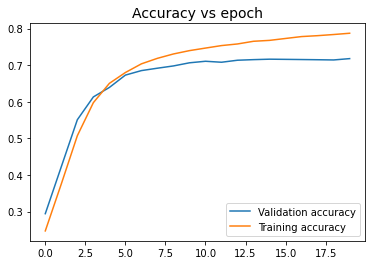

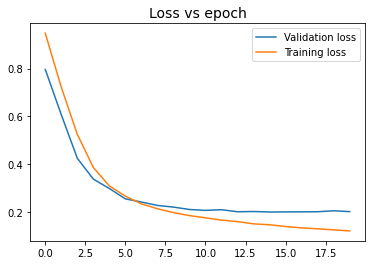

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.11976
accuracy,0.78738
val_loss,0.20067
val_accuracy,0.71806
_runtime,189
_timestamp,1620283622
_step,20
best_val_loss,0.19896
best_epoch,14
inference_val_accuracy,0.30155


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▆▆▇▇▇▇▇▇█████████
val_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇█████████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 3krj7b31 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 128
wandb: 	num_layers: 3


cell_LSTM_ncell_128_nlayer_3_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 43s - loss: 1.0002 - accuracy: 0.2327 - val_loss: 0.7529 - val_accuracy: 0.3185
Epoch 2/20
647/647 - 18s - loss: 0.6993 - accuracy: 0.3811 - val_loss: 0.6627 - val_accuracy: 0.3894
Epoch 3/20
647/647 - 18s - loss: 0.5655 - accuracy: 0.4692 - val_loss: 0.4990 - val_accuracy: 0.4916
Epoch 4/20
647/647 - 18s - loss: 0.4604 - accuracy: 0.5407 - val_loss: 0.4092 - val_accuracy: 0.5560
Epoch 5/20
647/647 - 18s - loss: 0.3778 - accuracy: 0.6020 - val_loss: 0.3692 - val_accuracy: 0.5918
Epoch 6/20
647/647 - 18s - loss: 0.3179 - accuracy: 0.6451 - val_loss: 0.3173 - val_accuracy: 0.6282
Epoch 7/20
647/647 - 17s - loss: 0.2681 - accuracy: 0.6802 - val_loss: 0.2670 - val_accuracy: 0.6659
Epoch 8/20
647/647 - 18s - loss: 0.2311 - accuracy: 0.7074 - val_loss: 0.2499 - val_accuracy: 0.6785
Epoch 9/20
647/647 - 17s - loss: 0.2035 - accuracy: 0.7270 - val_loss: 0.2342 - val_accuracy: 0.6915
Epoch 10/20
647/647 - 18s - loss: 0.1817 - ac

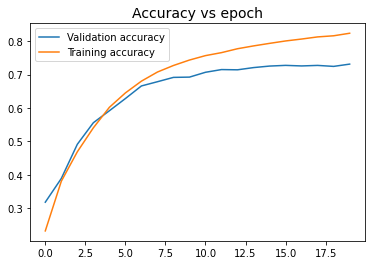

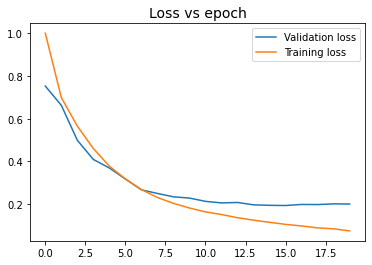

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.0745
accuracy,0.82337
val_loss,0.20032
val_accuracy,0.73111
_runtime,417
_timestamp,1620284045
_step,20
best_val_loss,0.19344
best_epoch,15
inference_val_accuracy,0.32562


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇███████
val_loss,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▇▇▇▇██████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: or6gayju with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_layers: 2


cell_GRU_ncell_256_nlayer_2_emb_32_dp_0.1_bm_3
Epoch 1/20
647/647 - 202s - loss: 0.8200 - accuracy: 0.3232 - val_loss: 0.5441 - val_accuracy: 0.4708
Epoch 2/20
647/647 - 190s - loss: 0.4251 - accuracy: 0.5694 - val_loss: 0.2917 - val_accuracy: 0.6472
Epoch 3/20
647/647 - 189s - loss: 0.2595 - accuracy: 0.6832 - val_loss: 0.2187 - val_accuracy: 0.6993
Epoch 4/20
647/647 - 190s - loss: 0.1998 - accuracy: 0.7255 - val_loss: 0.1915 - val_accuracy: 0.7163
Epoch 5/20
647/647 - 189s - loss: 0.1695 - accuracy: 0.7476 - val_loss: 0.1749 - val_accuracy: 0.7317
Epoch 6/20
647/647 - 189s - loss: 0.1464 - accuracy: 0.7651 - val_loss: 0.1717 - val_accuracy: 0.7341
Epoch 7/20
647/647 - 190s - loss: 0.1368 - accuracy: 0.7723 - val_loss: 0.1623 - val_accuracy: 0.7431
Epoch 8/20
647/647 - 189s - loss: 0.1210 - accuracy: 0.7844 - val_loss: 0.1624 - val_accuracy: 0.7443
Epoch 9/20
647/647 - 189s - loss: 0.1107 - accuracy: 0.7927 - val_loss: 0.1583 - val_accuracy: 0.7479
Epoch 10/20
647/647 - 188s - loss: 

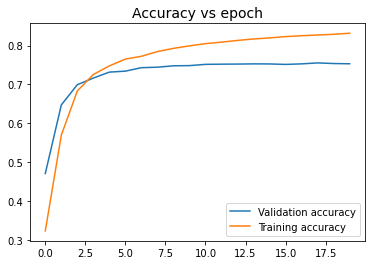

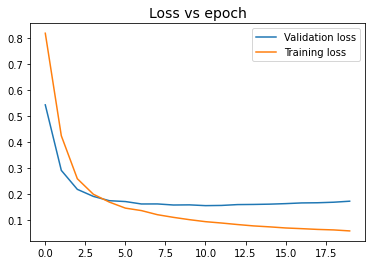

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.05851
accuracy,0.83162
val_loss,0.17297
val_accuracy,0.75309
_runtime,3807
_timestamp,1620287879
_step,20
best_val_loss,0.1559
best_epoch,10
inference_val_accuracy,0.37977


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▇▇▇▇▇▇███████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇▇▇██████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: o3630l24 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 128
wandb: 	num_layers: 2


cell_RNN_ncell_128_nlayer_2_emb_32_dp_0.1_bm_1
Epoch 1/20
647/647 - 84s - loss: 0.8682 - accuracy: 0.3089 - val_loss: 0.6473 - val_accuracy: 0.4051
Epoch 2/20
647/647 - 77s - loss: 0.6531 - accuracy: 0.4200 - val_loss: 0.5324 - val_accuracy: 0.4651
Epoch 3/20
647/647 - 79s - loss: 0.5832 - accuracy: 0.4547 - val_loss: 0.4692 - val_accuracy: 0.5111
Epoch 4/20
647/647 - 79s - loss: 0.5530 - accuracy: 0.4731 - val_loss: 0.4342 - val_accuracy: 0.5333
Epoch 5/20
647/647 - 78s - loss: 0.5239 - accuracy: 0.4899 - val_loss: 0.4312 - val_accuracy: 0.5325
Epoch 6/20
647/647 - 81s - loss: 0.5211 - accuracy: 0.4933 - val_loss: 0.4103 - val_accuracy: 0.5439
Epoch 7/20
647/647 - 77s - loss: 0.4961 - accuracy: 0.5080 - val_loss: 0.4408 - val_accuracy: 0.5256
Epoch 8/20
647/647 - 79s - loss: 0.4970 - accuracy: 0.5074 - val_loss: 0.3827 - val_accuracy: 0.5659
Epoch 9/20
647/647 - 78s - loss: 0.4793 - accuracy: 0.5189 - val_loss: 0.3710 - val_accuracy: 0.5738
Epoch 10/20
647/647 - 77s - loss: 0.4679 - a

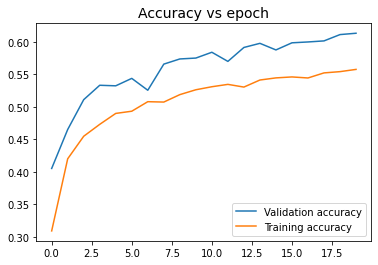

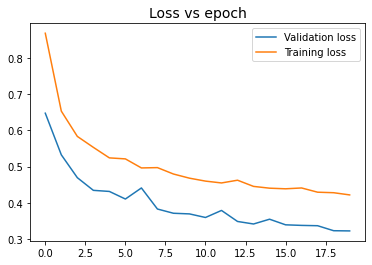

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.42164
accuracy,0.55776
val_loss,0.32217
val_accuracy,0.61347
_runtime,1590
_timestamp,1620289476
_step,20
best_val_loss,0.32217
best_epoch,19
inference_val_accuracy,0.12289


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
val_loss,█▆▄▃▃▃▄▂▂▂▂▂▂▁▂▁▁▁▁▁
val_accuracy,▁▃▅▅▅▆▅▆▇▇▇▇▇▇▇█████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: gxbnnv2w with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 512
wandb: 	num_layers: 3


cell_LSTM_ncell_512_nlayer_3_emb_16_dp_0.1_bm_3
Epoch 1/20
647/647 - 358s - loss: 0.8847 - accuracy: 0.2915 - val_loss: 0.6284 - val_accuracy: 0.4010
Epoch 2/20
647/647 - 343s - loss: 0.5233 - accuracy: 0.4942 - val_loss: 0.3988 - val_accuracy: 0.5625
Epoch 3/20
647/647 - 343s - loss: 0.3535 - accuracy: 0.6126 - val_loss: 0.2905 - val_accuracy: 0.6472
Epoch 4/20
647/647 - 344s - loss: 0.2569 - accuracy: 0.6839 - val_loss: 0.2402 - val_accuracy: 0.6846
Epoch 5/20
647/647 - 336s - loss: 0.1996 - accuracy: 0.7257 - val_loss: 0.2183 - val_accuracy: 0.7034
Epoch 6/20
647/647 - 336s - loss: 0.1583 - accuracy: 0.7562 - val_loss: 0.2092 - val_accuracy: 0.7152
Epoch 7/20
647/647 - 338s - loss: 0.1303 - accuracy: 0.7775 - val_loss: 0.2034 - val_accuracy: 0.7225
Epoch 8/20
647/647 - 339s - loss: 0.1090 - accuracy: 0.7930 - val_loss: 0.2079 - val_accuracy: 0.7250
Epoch 9/20
647/647 - 343s - loss: 0.0931 - accuracy: 0.8053 - val_loss: 0.2034 - val_accuracy: 0.7282
Epoch 10/20
647/647 - 341s - loss:

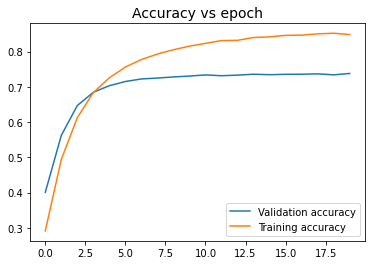

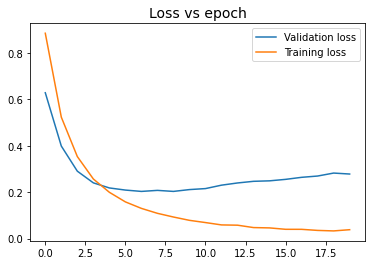

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.03847
accuracy,0.8484
val_loss,0.27828
val_accuracy,0.73797
_runtime,6882
_timestamp,1620296368
_step,20
best_val_loss,0.20339
best_epoch,6
inference_val_accuracy,0.32701


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇███████████
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
val_accuracy,▁▄▆▇▇███████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: y5e4b3fp with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 128
wandb: 	num_layers: 1


cell_LSTM_ncell_128_nlayer_1_emb_32_dp_0.1_bm_1
Epoch 1/20
647/647 - 117s - loss: 0.9615 - accuracy: 0.2433 - val_loss: 0.7752 - val_accuracy: 0.3146
Epoch 2/20
647/647 - 108s - loss: 0.6778 - accuracy: 0.4045 - val_loss: 0.5324 - val_accuracy: 0.4823
Epoch 3/20
647/647 - 109s - loss: 0.5049 - accuracy: 0.5121 - val_loss: 0.4154 - val_accuracy: 0.5495
Epoch 4/20
647/647 - 109s - loss: 0.4092 - accuracy: 0.5731 - val_loss: 0.3362 - val_accuracy: 0.6111
Epoch 5/20
647/647 - 110s - loss: 0.3541 - accuracy: 0.6104 - val_loss: 0.2993 - val_accuracy: 0.6396
Epoch 6/20
647/647 - 110s - loss: 0.3189 - accuracy: 0.6359 - val_loss: 0.2761 - val_accuracy: 0.6562
Epoch 7/20
647/647 - 105s - loss: 0.2938 - accuracy: 0.6528 - val_loss: 0.2628 - val_accuracy: 0.6634
Epoch 8/20
647/647 - 109s - loss: 0.2759 - accuracy: 0.6665 - val_loss: 0.2447 - val_accuracy: 0.6770
Epoch 9/20
647/647 - 109s - loss: 0.2607 - accuracy: 0.6769 - val_loss: 0.2322 - val_accuracy: 0.6891
Epoch 10/20
647/647 - 109s - loss:

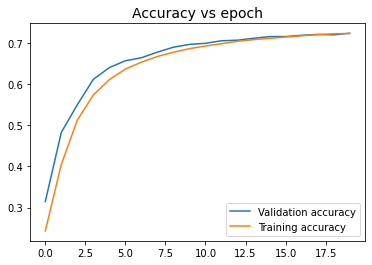

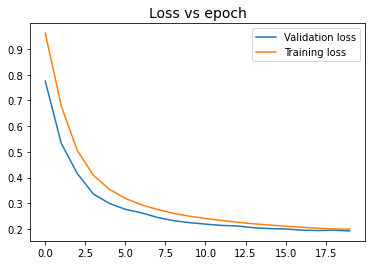

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.199
accuracy,0.72229
val_loss,0.19227
val_accuracy,0.72289
_runtime,2208
_timestamp,1620298584
_step,20
best_val_loss,0.19227
best_epoch,19
inference_val_accuracy,0.3152


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▆▇▇▇▇▇██████████
val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇███████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: rns5k2nk with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 256
wandb: 	num_layers: 1


cell_LSTM_ncell_256_nlayer_1_emb_64_dp_0.1_bm_1
Epoch 1/20
647/647 - 116s - loss: 0.8812 - accuracy: 0.2939 - val_loss: 0.5706 - val_accuracy: 0.4585
Epoch 2/20
647/647 - 109s - loss: 0.4755 - accuracy: 0.5363 - val_loss: 0.3541 - val_accuracy: 0.5959
Epoch 3/20
647/647 - 109s - loss: 0.3305 - accuracy: 0.6322 - val_loss: 0.2803 - val_accuracy: 0.6544
Epoch 4/20
647/647 - 113s - loss: 0.2674 - accuracy: 0.6765 - val_loss: 0.2364 - val_accuracy: 0.6870
Epoch 5/20
647/647 - 110s - loss: 0.2310 - accuracy: 0.7025 - val_loss: 0.2157 - val_accuracy: 0.7029
Epoch 6/20
647/647 - 110s - loss: 0.2065 - accuracy: 0.7203 - val_loss: 0.2008 - val_accuracy: 0.7126
Epoch 7/20
647/647 - 110s - loss: 0.1886 - accuracy: 0.7334 - val_loss: 0.1917 - val_accuracy: 0.7194
Epoch 8/20
647/647 - 111s - loss: 0.1748 - accuracy: 0.7441 - val_loss: 0.1878 - val_accuracy: 0.7238
Epoch 9/20
647/647 - 111s - loss: 0.1654 - accuracy: 0.7506 - val_loss: 0.1802 - val_accuracy: 0.7311
Epoch 10/20
647/647 - 110s - loss:

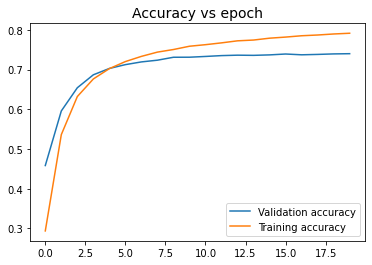

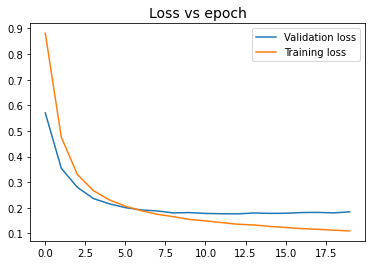

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.10993
accuracy,0.79161
val_loss,0.18438
val_accuracy,0.74012
_runtime,2229
_timestamp,1620300821
_step,20
best_val_loss,0.17633
best_epoch,12
inference_val_accuracy,0.35802


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▆▇▇▇▇▇███████████
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇█████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: d3uf30pz with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 256
wandb: 	num_layers: 2


cell_GRU_ncell_256_nlayer_2_emb_64_dp_0_bm_1
Epoch 1/20
647/647 - 30s - loss: 0.7873 - accuracy: 0.3480 - val_loss: 0.4854 - val_accuracy: 0.5129
Epoch 2/20
647/647 - 11s - loss: 0.3601 - accuracy: 0.6155 - val_loss: 0.2852 - val_accuracy: 0.6497
Epoch 3/20
647/647 - 11s - loss: 0.2153 - accuracy: 0.7178 - val_loss: 0.2023 - val_accuracy: 0.7118
Epoch 4/20
647/647 - 11s - loss: 0.1589 - accuracy: 0.7590 - val_loss: 0.1807 - val_accuracy: 0.7272
Epoch 5/20
647/647 - 11s - loss: 0.1287 - accuracy: 0.7820 - val_loss: 0.1707 - val_accuracy: 0.7359
Epoch 6/20
647/647 - 11s - loss: 0.1052 - accuracy: 0.8005 - val_loss: 0.1620 - val_accuracy: 0.7430
Epoch 7/20
647/647 - 11s - loss: 0.0882 - accuracy: 0.8142 - val_loss: 0.1627 - val_accuracy: 0.7463
Epoch 8/20
647/647 - 11s - loss: 0.0753 - accuracy: 0.8239 - val_loss: 0.1676 - val_accuracy: 0.7433
Epoch 9/20


wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)


647/647 - 11s - loss: 0.0639 - accuracy: 0.8330 - val_loss: 0.1709 - val_accuracy: 0.7416
Epoch 10/20


wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.


647/647 - 11s - loss: 0.0520 - accuracy: 0.8431 - val_loss: 0.1701 - val_accuracy: 0.7451
Epoch 11/20
647/647 - 11s - loss: 0.0441 - accuracy: 0.8493 - val_loss: 0.1767 - val_accuracy: 0.7431
Epoch 12/20
647/647 - 11s - loss: 0.0404 - accuracy: 0.8517 - val_loss: 0.1776 - val_accuracy: 0.7438
Epoch 13/20


wandb: Network error (HTTPError), entering retry loop.


647/647 - 11s - loss: 0.0316 - accuracy: 0.8597 - val_loss: 0.1806 - val_accuracy: 0.7445
Epoch 14/20
647/647 - 11s - loss: 0.0299 - accuracy: 0.8608 - val_loss: 0.1842 - val_accuracy: 0.7456
Epoch 15/20


wandb: Network error (HTTPError), entering retry loop.


647/647 - 11s - loss: 0.0236 - accuracy: 0.8664 - val_loss: 0.1870 - val_accuracy: 0.7449
Epoch 16/20


wandb: Network error (HTTPError), entering retry loop.


647/647 - 11s - loss: 0.0215 - accuracy: 0.8681 - val_loss: 0.1941 - val_accuracy: 0.7439
Epoch 17/20


wandb: Network error (HTTPError), entering retry loop.


647/647 - 12s - loss: 0.0203 - accuracy: 0.8687 - val_loss: 0.1962 - val_accuracy: 0.7422
Epoch 18/20
647/647 - 11s - loss: 0.0189 - accuracy: 0.8697 - val_loss: 0.2043 - val_accuracy: 0.7369
Epoch 19/20
647/647 - 11s - loss: 0.0180 - accuracy: 0.8705 - val_loss: 0.1992 - val_accuracy: 0.7435
Epoch 20/20
647/647 - 11s - loss: 0.0130 - accuracy: 0.8746 - val_loss: 0.2018 - val_accuracy: 0.7451
Validation accuracy based on whole string matching = 34.320759083545475 %


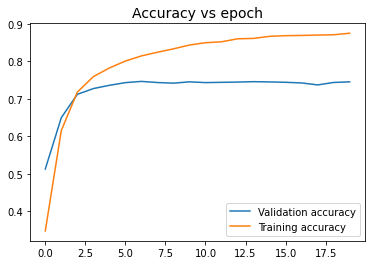

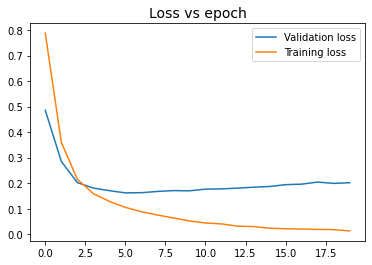

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: 500 encountered ({"errors":[{"message":"Error 1040: Too many connections","path":["project"]}],"data":{"project":null}}), retrying request
wandb: Network error resolved after 0:04:46.913992, resuming normal operation.


epoch,19
loss,0.01299
accuracy,0.87456
val_loss,0.20176
val_accuracy,0.74507
_runtime,269
_timestamp,1620301099
_step,20
best_val_loss,0.16197
best_epoch,5
inference_val_accuracy,0.34321


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▆▇▇▇▇▇███████████
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
val_accuracy,▁▅▇▇████████████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: z76tn155 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_layers: 2


cell_RNN_ncell_512_nlayer_2_emb_64_dp_0.1_bm_1
Epoch 1/20
647/647 - 88s - loss: 0.8157 - accuracy: 0.3382 - val_loss: 0.6678 - val_accuracy: 0.3979
Epoch 2/20
647/647 - 81s - loss: 0.6624 - accuracy: 0.4166 - val_loss: 0.5508 - val_accuracy: 0.4673
Epoch 3/20
647/647 - 82s - loss: 0.5498 - accuracy: 0.4846 - val_loss: 0.5244 - val_accuracy: 0.4803
Epoch 4/20
647/647 - 81s - loss: 0.5015 - accuracy: 0.5132 - val_loss: 0.4361 - val_accuracy: 0.5398
Epoch 5/20
647/647 - 81s - loss: 0.4575 - accuracy: 0.5405 - val_loss: 0.4052 - val_accuracy: 0.5601
Epoch 6/20
647/647 - 80s - loss: 0.4255 - accuracy: 0.5594 - val_loss: 0.4019 - val_accuracy: 0.5605
Epoch 7/20
647/647 - 81s - loss: 0.4051 - accuracy: 0.5730 - val_loss: 0.3640 - val_accuracy: 0.5862
Epoch 8/20
647/647 - 82s - loss: 0.3814 - accuracy: 0.5894 - val_loss: 0.3524 - val_accuracy: 0.5974
Epoch 9/20
647/647 - 81s - loss: 0.3584 - accuracy: 0.6053 - val_loss: 0.3330 - val_accuracy: 0.6116
Epoch 10/20
647/647 - 81s - loss: 0.3435 - a

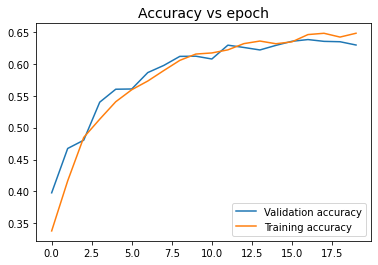

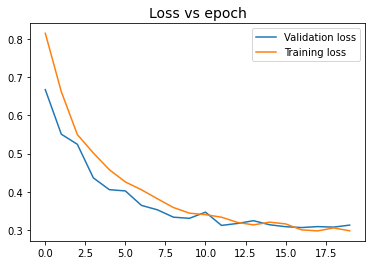

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.29731
accuracy,0.64781
val_loss,0.31224
val_accuracy,0.62937
_runtime,1637
_timestamp,1620302854
_step,20
best_val_loss,0.30583
best_epoch,16
inference_val_accuracy,0.14372


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇████████
val_loss,█▆▅▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▆▆▆▇▇▇▇█████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: i5cqitxa with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_layers: 1


cell_GRU_ncell_256_nlayer_1_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 17s - loss: 0.9380 - accuracy: 0.2525 - val_loss: 0.7668 - val_accuracy: 0.3148
Epoch 2/20
647/647 - 8s - loss: 0.6368 - accuracy: 0.4346 - val_loss: 0.5069 - val_accuracy: 0.4903
Epoch 3/20
647/647 - 8s - loss: 0.4012 - accuracy: 0.5870 - val_loss: 0.3195 - val_accuracy: 0.6256
Epoch 4/20
647/647 - 8s - loss: 0.2753 - accuracy: 0.6754 - val_loss: 0.2671 - val_accuracy: 0.6680
Epoch 5/20
647/647 - 8s - loss: 0.2165 - accuracy: 0.7173 - val_loss: 0.2177 - val_accuracy: 0.7032
Epoch 6/20
647/647 - 8s - loss: 0.1804 - accuracy: 0.7435 - val_loss: 0.2090 - val_accuracy: 0.7079
Epoch 7/20
647/647 - 8s - loss: 0.1575 - accuracy: 0.7607 - val_loss: 0.1984 - val_accuracy: 0.7166
Epoch 8/20
647/647 - 8s - loss: 0.1373 - accuracy: 0.7758 - val_loss: 0.1925 - val_accuracy: 0.7222
Epoch 9/20
647/647 - 8s - loss: 0.1231 - accuracy: 0.7869 - val_loss: 0.1969 - val_accuracy: 0.7170
Epoch 10/20
647/647 - 8s - loss: 0.1166 - accuracy: 0.

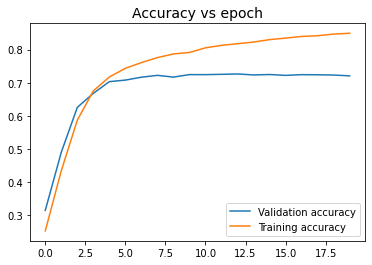

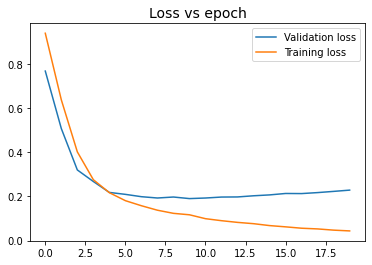

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.04359
accuracy,0.84934
val_loss,0.22817
val_accuracy,0.72073
_runtime,192
_timestamp,1620303055
_step,20
best_val_loss,0.18985
best_epoch,9
inference_val_accuracy,0.2916


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▆▇▇▇▇▇▇█████████
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇████████████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 7byo2g6k with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 512
wandb: 	num_layers: 1


cell_RNN_ncell_512_nlayer_1_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 32s - loss: 1.0018 - accuracy: 0.2161 - val_loss: 0.9114 - val_accuracy: 0.2258
Epoch 2/20
647/647 - 29s - loss: 0.8605 - accuracy: 0.2775 - val_loss: 0.7959 - val_accuracy: 0.2837
Epoch 3/20
647/647 - 30s - loss: 0.7764 - accuracy: 0.3249 - val_loss: 0.7531 - val_accuracy: 0.3114
Epoch 4/20
647/647 - 30s - loss: 0.7314 - accuracy: 0.3586 - val_loss: 0.7522 - val_accuracy: 0.3195
Epoch 5/20
647/647 - 30s - loss: 0.7047 - accuracy: 0.3741 - val_loss: 0.7051 - val_accuracy: 0.3509
Epoch 6/20
647/647 - 30s - loss: 0.6776 - accuracy: 0.3898 - val_loss: 0.6905 - val_accuracy: 0.3648
Epoch 7/20
647/647 - 30s - loss: 0.6541 - accuracy: 0.4037 - val_loss: 0.7414 - val_accuracy: 0.3321
Epoch 8/20
647/647 - 30s - loss: 0.7407 - accuracy: 0.3503 - val_loss: 0.7638 - val_accuracy: 0.3317
Epoch 9/20
647/647 - 30s - loss: 0.6791 - accuracy: 0.3879 - val_loss: 0.6800 - val_accuracy: 0.3706
Epoch 10/20
647/647 - 30s - loss: 0.6491 - acc

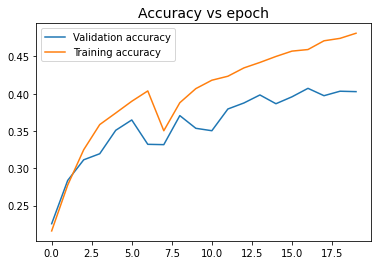

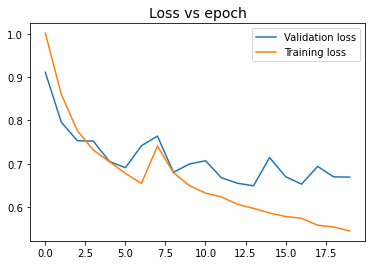

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.54438
accuracy,0.48094
val_loss,0.66885
val_accuracy,0.40272
_runtime,616
_timestamp,1620303679
_step,20
best_val_loss,0.64878
best_epoch,13
inference_val_accuracy,0.00069


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▃▄▃▃▂▂▂▂▂▂▁▁▁▁
accuracy,▁▃▄▅▅▆▆▅▆▆▆▆▇▇▇▇▇███
val_loss,█▅▄▄▃▂▃▄▂▂▃▁▁▁▃▂▁▂▂▂
val_accuracy,▁▃▄▅▆▆▅▅▇▆▆▇▇█▇█████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: sfp7uyq6 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 128
wandb: 	num_layers: 1


cell_GRU_ncell_128_nlayer_1_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 17s - loss: 0.9609 - accuracy: 0.2398 - val_loss: 0.8302 - val_accuracy: 0.2703
Epoch 2/20
647/647 - 8s - loss: 0.8119 - accuracy: 0.3124 - val_loss: 0.7526 - val_accuracy: 0.3194
Epoch 3/20
647/647 - 8s - loss: 0.6907 - accuracy: 0.3902 - val_loss: 0.6204 - val_accuracy: 0.4167
Epoch 4/20
647/647 - 8s - loss: 0.5922 - accuracy: 0.4576 - val_loss: 0.5359 - val_accuracy: 0.4693
Epoch 5/20
647/647 - 8s - loss: 0.5097 - accuracy: 0.5130 - val_loss: 0.4683 - val_accuracy: 0.5226
Epoch 6/20
647/647 - 8s - loss: 0.4362 - accuracy: 0.5611 - val_loss: 0.4043 - val_accuracy: 0.5649
Epoch 7/20
647/647 - 8s - loss: 0.3747 - accuracy: 0.6040 - val_loss: 0.3519 - val_accuracy: 0.6021
Epoch 8/20
647/647 - 8s - loss: 0.3270 - accuracy: 0.6379 - val_loss: 0.3158 - val_accuracy: 0.6303
Epoch 9/20
647/647 - 8s - loss: 0.2913 - accuracy: 0.6623 - val_loss: 0.2962 - val_accuracy: 0.6449
Epoch 10/20
647/647 - 8s - loss: 0.2665 - accuracy: 0.

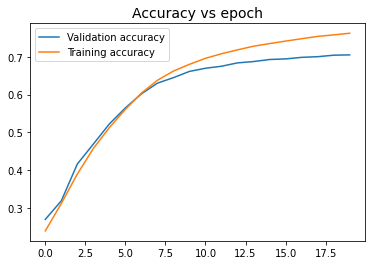

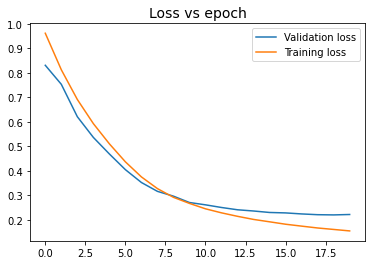

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.15433
accuracy,0.76222
val_loss,0.22132
val_accuracy,0.70504
_runtime,185
_timestamp,1620303872
_step,20
best_val_loss,0.21966
best_epoch,18
inference_val_accuracy,0.26869


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇███████
val_loss,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▆▆▇▇▇▇█████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: akg8k6l0 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 128
wandb: 	num_layers: 1


cell_LSTM_ncell_128_nlayer_1_emb_16_dp_0.1_bm_3
Epoch 1/20
647/647 - 116s - loss: 0.9742 - accuracy: 0.2363 - val_loss: 0.8195 - val_accuracy: 0.2938
Epoch 2/20
647/647 - 110s - loss: 0.7842 - accuracy: 0.3345 - val_loss: 0.6725 - val_accuracy: 0.3867
Epoch 3/20
647/647 - 109s - loss: 0.6560 - accuracy: 0.4200 - val_loss: 0.5651 - val_accuracy: 0.4645
Epoch 4/20
647/647 - 109s - loss: 0.5539 - accuracy: 0.4828 - val_loss: 0.4651 - val_accuracy: 0.5250
Epoch 5/20
647/647 - 109s - loss: 0.4741 - accuracy: 0.5325 - val_loss: 0.3972 - val_accuracy: 0.5752
Epoch 6/20
647/647 - 109s - loss: 0.4139 - accuracy: 0.5704 - val_loss: 0.3428 - val_accuracy: 0.6109
Epoch 7/20
647/647 - 110s - loss: 0.3697 - accuracy: 0.6004 - val_loss: 0.3098 - val_accuracy: 0.6343
Epoch 8/20
647/647 - 109s - loss: 0.3394 - accuracy: 0.6201 - val_loss: 0.2921 - val_accuracy: 0.6478
Epoch 9/20
647/647 - 110s - loss: 0.3174 - accuracy: 0.6358 - val_loss: 0.2698 - val_accuracy: 0.6597
Epoch 10/20
647/647 - 109s - loss:

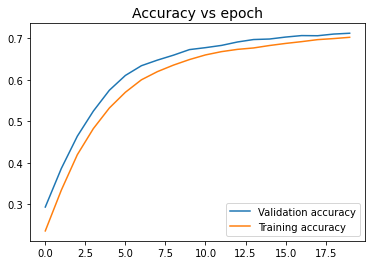

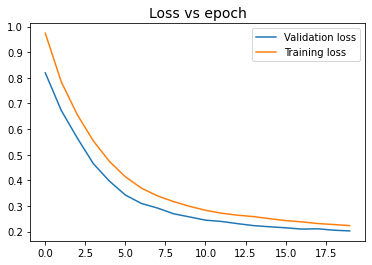

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.22349
accuracy,0.70277
val_loss,0.20267
val_accuracy,0.71257
_runtime,2213
_timestamp,1620306098
_step,20
best_val_loss,0.20267
best_epoch,19
inference_val_accuracy,0.29044


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▄▅▅▆▆▇▇▇▇▇████████
val_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: hwfejyge with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_layers: 1


cell_RNN_ncell_512_nlayer_1_emb_32_dp_0_bm_3
Epoch 1/20
647/647 - 32s - loss: 1.0066 - accuracy: 0.2197 - val_loss: 0.8856 - val_accuracy: 0.2431
Epoch 2/20
647/647 - 30s - loss: 0.8288 - accuracy: 0.3102 - val_loss: 0.8245 - val_accuracy: 0.3040
Epoch 3/20
647/647 - 30s - loss: 0.7727 - accuracy: 0.3411 - val_loss: 0.7662 - val_accuracy: 0.3103
Epoch 4/20
647/647 - 30s - loss: 0.7735 - accuracy: 0.3351 - val_loss: 0.8318 - val_accuracy: 0.2715
Epoch 5/20
647/647 - 29s - loss: 0.7637 - accuracy: 0.3361 - val_loss: 0.7907 - val_accuracy: 0.3200
Epoch 6/20
647/647 - 30s - loss: 0.7300 - accuracy: 0.3609 - val_loss: 0.7512 - val_accuracy: 0.3374
Epoch 7/20
647/647 - 30s - loss: 0.7002 - accuracy: 0.3786 - val_loss: 0.7131 - val_accuracy: 0.3395
Epoch 8/20
647/647 - 30s - loss: 0.6873 - accuracy: 0.3871 - val_loss: 0.7104 - val_accuracy: 0.3578
Epoch 9/20
647/647 - 29s - loss: 0.6758 - accuracy: 0.3946 - val_loss: 0.6755 - val_accuracy: 0.3784
Epoch 10/20
647/647 - 30s - loss: 0.6643 - acc

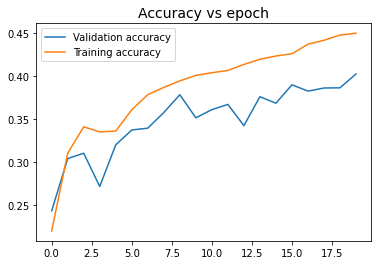

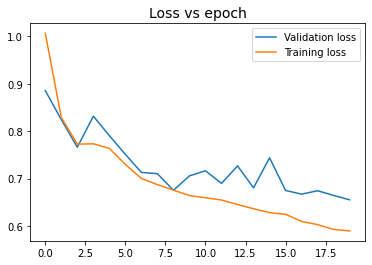

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.58975
accuracy,0.4502
val_loss,0.65532
val_accuracy,0.40275
_runtime,609
_timestamp,1620306717
_step,20
best_val_loss,0.65532
best_epoch,19
inference_val_accuracy,0.00046


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
accuracy,▁▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
val_loss,█▆▄▆▅▄▃▃▂▃▃▂▃▂▄▂▁▂▁▁
val_accuracy,▁▄▄▂▄▅▅▆▇▆▆▆▅▇▇▇▇▇▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 6236wgfv with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_layers: 3


cell_RNN_ncell_512_nlayer_3_emb_32_dp_0.1_bm_3
Epoch 1/20
647/647 - 129s - loss: 0.9269 - accuracy: 0.2859 - val_loss: 0.8891 - val_accuracy: 0.2637
Epoch 2/20
647/647 - 122s - loss: 0.8127 - accuracy: 0.3242 - val_loss: 0.7648 - val_accuracy: 0.3182
Epoch 3/20
647/647 - 120s - loss: 0.7454 - accuracy: 0.3607 - val_loss: 0.7006 - val_accuracy: 0.3588
Epoch 4/20
647/647 - 121s - loss: 0.7183 - accuracy: 0.3752 - val_loss: 0.6765 - val_accuracy: 0.3816
Epoch 5/20
647/647 - 121s - loss: 0.6911 - accuracy: 0.3914 - val_loss: 0.6698 - val_accuracy: 0.3803
Epoch 6/20
647/647 - 121s - loss: 0.7324 - accuracy: 0.3694 - val_loss: 0.8893 - val_accuracy: 0.2515
Epoch 7/20
647/647 - 120s - loss: 0.8761 - accuracy: 0.2895 - val_loss: 0.8614 - val_accuracy: 0.2677
Epoch 8/20
647/647 - 121s - loss: 0.8277 - accuracy: 0.3118 - val_loss: 0.7687 - val_accuracy: 0.3193
Epoch 9/20
647/647 - 121s - loss: 0.8345 - accuracy: 0.3066 - val_loss: 0.7671 - val_accuracy: 0.3200
Epoch 10/20
647/647 - 119s - loss: 

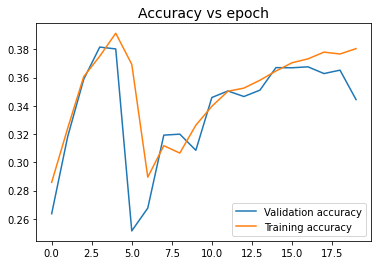

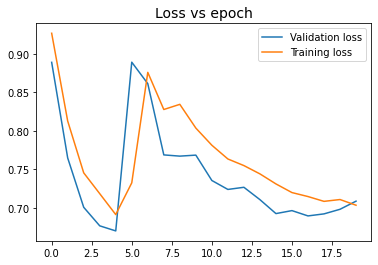

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.70325
accuracy,0.38055
val_loss,0.70854
val_accuracy,0.34447
_runtime,2443
_timestamp,1620309169
_step,20
best_val_loss,0.66984
best_epoch,4
inference_val_accuracy,0.00069


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▂▁▂▆▅▅▄▄▃▃▃▂▂▂▂▂▁
accuracy,▁▄▆▇█▇▁▃▂▄▅▅▅▆▆▇▇▇▇▇
val_loss,█▄▂▁▁█▇▄▄▄▃▃▃▂▂▂▂▂▂▂
val_accuracy,▂▅▇██▁▂▅▅▄▆▆▆▆▇▇▇▇▇▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 4evta7ed with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_layers: 1


cell_LSTM_ncell_512_nlayer_1_emb_64_dp_0.1_bm_1
Epoch 1/20
647/647 - 118s - loss: 0.8296 - accuracy: 0.3279 - val_loss: 0.5495 - val_accuracy: 0.4677
Epoch 2/20
647/647 - 114s - loss: 0.4317 - accuracy: 0.5644 - val_loss: 0.3264 - val_accuracy: 0.6227
Epoch 3/20
647/647 - 113s - loss: 0.2801 - accuracy: 0.6698 - val_loss: 0.2443 - val_accuracy: 0.6777
Epoch 4/20
647/647 - 111s - loss: 0.2148 - accuracy: 0.7155 - val_loss: 0.2094 - val_accuracy: 0.7088
Epoch 5/20
647/647 - 112s - loss: 0.1790 - accuracy: 0.7421 - val_loss: 0.1965 - val_accuracy: 0.7170
Epoch 6/20
647/647 - 116s - loss: 0.1547 - accuracy: 0.7600 - val_loss: 0.1867 - val_accuracy: 0.7265
Epoch 7/20
647/647 - 118s - loss: 0.1378 - accuracy: 0.7725 - val_loss: 0.1826 - val_accuracy: 0.7301
Epoch 8/20
647/647 - 116s - loss: 0.1227 - accuracy: 0.7835 - val_loss: 0.1821 - val_accuracy: 0.7330
Epoch 9/20
647/647 - 114s - loss: 0.1096 - accuracy: 0.7939 - val_loss: 0.1836 - val_accuracy: 0.7353
Epoch 10/20
647/647 - 113s - loss:

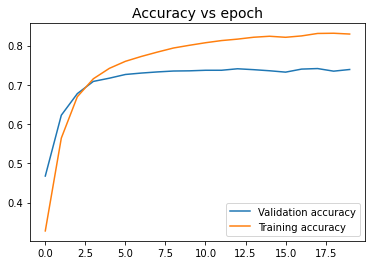

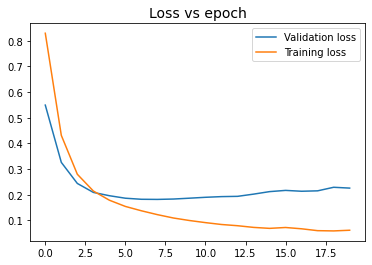

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.06198
accuracy,0.82948
val_loss,0.22617
val_accuracy,0.73916
_runtime,2285
_timestamp,1620311463
_step,20
best_val_loss,0.18212
best_epoch,7
inference_val_accuracy,0.35108


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▆▇▇▇▇▇███████████
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
val_accuracy,▁▅▆▇▇███████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: viepbkx7 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_layers: 2


cell_GRU_ncell_512_nlayer_2_emb_32_dp_0_bm_3
Epoch 1/20
647/647 - 32s - loss: 0.7129 - accuracy: 0.3905 - val_loss: 0.3699 - val_accuracy: 0.5889
Epoch 2/20
647/647 - 15s - loss: 0.2638 - accuracy: 0.6814 - val_loss: 0.2205 - val_accuracy: 0.6978
Epoch 3/20
647/647 - 15s - loss: 0.1615 - accuracy: 0.7561 - val_loss: 0.2044 - val_accuracy: 0.7093
Epoch 4/20
647/647 - 15s - loss: 0.1270 - accuracy: 0.7828 - val_loss: 0.1728 - val_accuracy: 0.7371
Epoch 5/20
647/647 - 15s - loss: 0.0888 - accuracy: 0.8123 - val_loss: 0.1784 - val_accuracy: 0.7347
Epoch 6/20
647/647 - 15s - loss: 0.0689 - accuracy: 0.8274 - val_loss: 0.1748 - val_accuracy: 0.7413
Epoch 7/20
647/647 - 15s - loss: 0.0501 - accuracy: 0.8427 - val_loss: 0.1796 - val_accuracy: 0.7452
Epoch 8/20
647/647 - 15s - loss: 0.0404 - accuracy: 0.8502 - val_loss: 0.1863 - val_accuracy: 0.7469
Epoch 9/20
647/647 - 15s - loss: 0.0319 - accuracy: 0.8574 - val_loss: 0.1939 - val_accuracy: 0.7442
Epoch 10/20
647/647 - 15s - loss: 0.0244 - acc

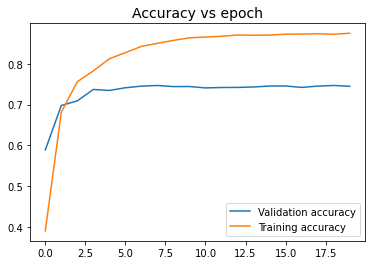

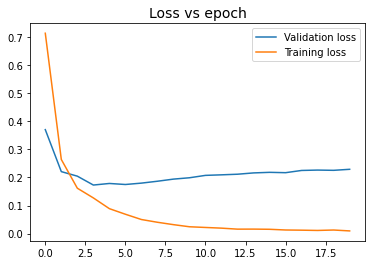

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00959
accuracy,0.8749
val_loss,0.22882
val_accuracy,0.74483
_runtime,342
_timestamp,1620311814
_step,20
best_val_loss,0.1728
best_epoch,3
inference_val_accuracy,0.35154


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇▇██████████████
val_loss,█▃▂▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃
val_accuracy,▁▆▆█▇███████████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: ypiw9u8j with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 512
wandb: 	num_layers: 3


cell_LSTM_ncell_512_nlayer_3_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 50s - loss: 0.8201 - accuracy: 0.3286 - val_loss: 0.5331 - val_accuracy: 0.4663
Epoch 2/20
647/647 - 24s - loss: 0.4052 - accuracy: 0.5819 - val_loss: 0.3324 - val_accuracy: 0.6237
Epoch 3/20
647/647 - 24s - loss: 0.2560 - accuracy: 0.6886 - val_loss: 0.2516 - val_accuracy: 0.6781
Epoch 4/20
647/647 - 23s - loss: 0.1790 - accuracy: 0.7455 - val_loss: 0.2265 - val_accuracy: 0.6952
Epoch 5/20
647/647 - 24s - loss: 0.1358 - accuracy: 0.7764 - val_loss: 0.2060 - val_accuracy: 0.7151
Epoch 6/20
647/647 - 24s - loss: 0.1010 - accuracy: 0.8024 - val_loss: 0.2108 - val_accuracy: 0.7191
Epoch 7/20
647/647 - 24s - loss: 0.0801 - accuracy: 0.8180 - val_loss: 0.2219 - val_accuracy: 0.7202
Epoch 8/20
647/647 - 24s - loss: 0.0646 - accuracy: 0.8297 - val_loss: 0.2267 - val_accuracy: 0.7241
Epoch 9/20
647/647 - 24s - loss: 0.0501 - accuracy: 0.8406 - val_loss: 0.2325 - val_accuracy: 0.7285
Epoch 10/20
647/647 - 24s - loss: 0.0393 - ac

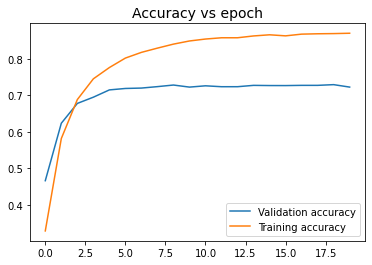

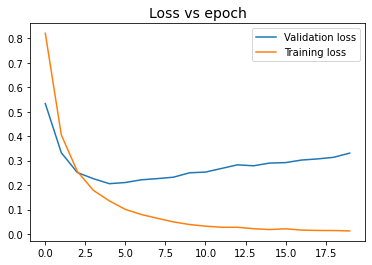

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.01321
accuracy,0.87044
val_loss,0.33077
val_accuracy,0.72283
_runtime,539
_timestamp,1620312363
_step,20
best_val_loss,0.20598
best_epoch,4
inference_val_accuracy,0.29808


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▆▇▇▇▇████████████
val_loss,█▄▂▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄
val_accuracy,▁▅▇▇████████████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: nj1geshh with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 128
wandb: 	num_layers: 3


cell_RNN_ncell_128_nlayer_3_emb_16_dp_0.1_bm_3
Epoch 1/20
647/647 - 129s - loss: 0.8846 - accuracy: 0.2974 - val_loss: 0.6770 - val_accuracy: 0.3876
Epoch 2/20


In [ ]:
# Sweep configuration
sweep_config = {
  "name": "Assignment3_new",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "cell_type": {
            "values": ["LSTM", "RNN", "GRU"]
        },
        "num_cells": {
            "values": [128, 256, 512]
        },
        "num_layers": {
            "values": [1, 2, 3]
        },
        "input_embedding_size": {
            "values": [16, 32, 64]
        },
        "dropout_fraction": {
            "values": [0, 0.1]
        },
        "beam_size": {
            "values": [1, 3]
        }
    }
}

# Generates a sweep id
# sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_3")
# print(f"Sweep ID = {sweep_id}")
wandb.agent("f82618vh", train_with_wandb, count=100)

# Training function (No WANDB)

Use this to train the model with the best choice of hyperparameters obtained from Wandb.

In [ ]:
def train(num_cells, cell_type, num_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    Function to train the model with the best set of hyperparameters (without WANDB)
    """
    # Define the model

    model = define_model(num_cells, cell_type, num_layers, num_layers, input_embedding_size, dropout_fraction, beam_size)
    print(model.summary())

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = 64,
            epochs = 20,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
            )

    # Save the trained model
    model.save("best_model_"+cell_type+str(num_encoder_layers)+".h5")

    if cell_type == "LSTM":
        cell = "lstm"
    else:
        cell = "rnngru"

    func1_name = "prepare_inference_model_" + cell + "_" + str(num_layers)
    func2_name = "transliterate_word_" + cell + "_" + str(num_layers)

    # Get the encoder and decoder model
    encoder_model, decoder_model = globals()[func1_name](model, num_cells)

    outputs = []
    n = encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in target_words]
    # Calculate training accuracy
    training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Training accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))


    outputs = []
    n = val_encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = val_encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in val_target_words]
    # Calculate validation accuracy
    validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Validation accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()

    return model, history

### Training with the Best Hyperparameters

These are the best hyperparameters that we got from WANDB.

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
___________________________________________________________________________________________

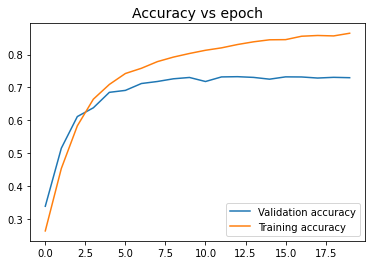

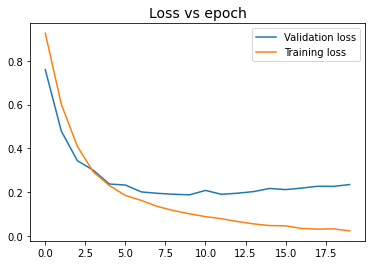

In [ ]:
# Best hyperparameters
num_cells = 256
cell_type = "LSTM"
num_layers = 2
num_encoder_layers = num_layers
num_decoder_layers = num_layers
input_embedding_size = 16
dropout_fraction = 0
beam_size = 1

model, history = train(num_cells, cell_type, num_layers, input_embedding_size, dropout_fraction, beam_size)

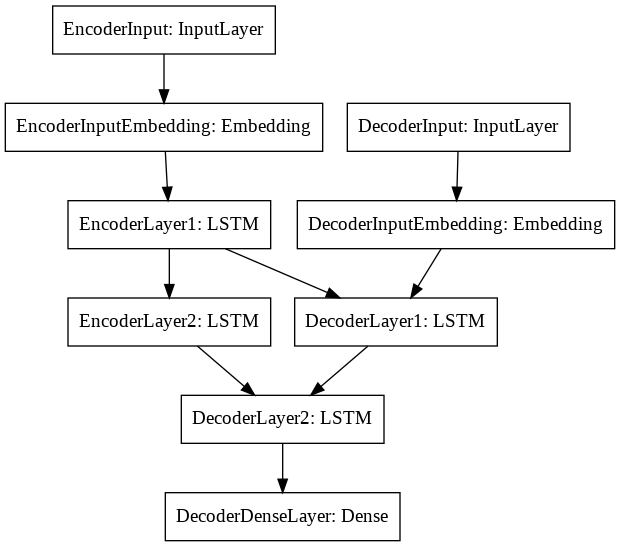

In [ ]:
keras.utils.plot_model(model)

### Inference, LSTM, 1 Decoder Layer

In [ ]:
model = keras.models.load_model("best_model.h5")
encoder_model, decoder_model = prepare_inference_model_lstm_1(model)

In [ ]:
outputs = []

n = encoder_input_array.shape[0]
batch_size = 1000

for i in range(0, n, batch_size):
    # Inputs
    query = encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm_1(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in target_words[:n]]

df_train = pd.DataFrame({"Input": input_words[:n], "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate training accuracy
training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))

Inference accuracy based on whole string matching = 80.36521949449752 %


In [ ]:
outputs = []

n = val_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = val_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in val_target_words]

df_val = pd.DataFrame({"Input": val_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

Inference accuracy based on whole string matching = 29.553344133302478 %


### Inference: LSTM, 2 Decoder Layers

In [ ]:
model = keras.models.load_model("best_model_LSTM2.h5")
encoder_model, decoder_model = prepare_inference_model_lstm_2(model)

In [ ]:
outputs = []

n = encoder_input_array.shape[0]
batch_size = 1000

for i in range(0, n, batch_size):
    # Inputs
    query = encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in target_words[:n]]

df_train = pd.DataFrame({"Input": input_words[:n], "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate training accuracy
training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))

Inference accuracy based on whole string matching = 90.9396541298827 %


In [ ]:
outputs = []

n = val_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = val_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in val_target_words]

df_val = pd.DataFrame({"Input": val_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

Inference accuracy based on whole string matching = 31.520481370053226 %


In [ ]:
outputs = []

n = test_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = test_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in test_target_words]

# Calculate test accuracy
test_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference accuracy based on whole string matching = {} %".format(test_inference_accuracy*100.0))

Inference accuracy based on whole string matching = 32.913102206213416 %


### Inference: LSTM, 3 Decoder Layers

In [ ]:
model = keras.models.load_model("best_model_LSTM3.h5")
encoder_model, decoder_model = prepare_inference_model_lstm_3(model)

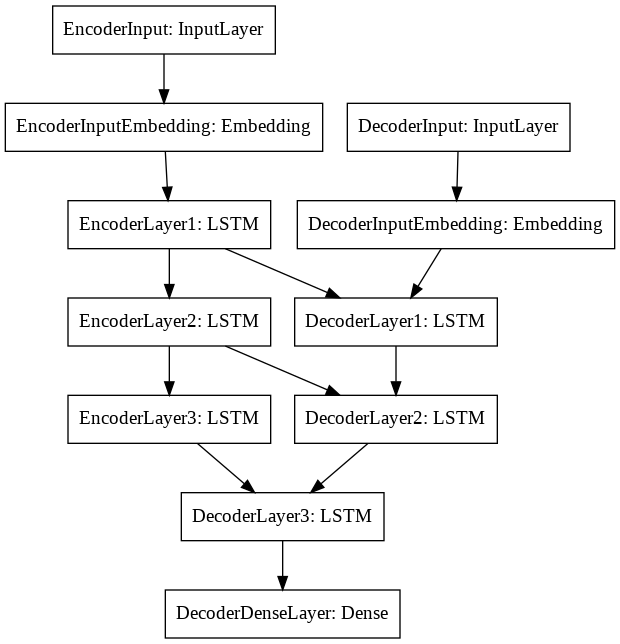

In [ ]:
keras.utils.plot_model(model)

In [ ]:
outputs = []

n = encoder_input_array.shape[0]
batch_size = 1000

for i in range(0, n, batch_size):
    # Inputs
    query = encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm_3(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in target_words[:n]]

df_train = pd.DataFrame({"Input": input_words[:n], "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate training accuracy
training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))

Inference accuracy based on whole string matching = 67.06977869149837 %


In [ ]:
outputs = []

n = val_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = val_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_lstm_3(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in val_target_words]

df_val = pd.DataFrame({"Input": val_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Inference accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

Inference accuracy based on whole string matching = 32.21476510067114 %


In [ ]:
model.evaluate([encoder_input_array, decoder_input_array], decoder_output_array)
model.evaluate([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
model.evaluate([test_encoder_input_array, test_decoder_input_array], test_decoder_output_array)

139/139 [==============================] - 2s 14ms/step - loss: 0.2336 - accuracy: 0.7312


[0.23358863592147827, 0.7311944961547852]